In [28]:
from bs4 import BeautifulSoup
import re
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# declare header to make sure imdb allows us to scrape
headers = {'user-agent':'Mozilla/5.0 \
            (Windows NT 10.0; Win64; x64) \
            AppleWebKit/537.36 (KHTML, like Gecko) \
            Chrome/84.0.4147.105 Safari/537.36'}

In [30]:
## First let's obtain a large list of cities on the cite
# using beautiful soup
url = 'https://www.houseful.ca/'
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")
script_tag = soup.find_all('script')[24].string
cities = re.split(r'nameForUrl', script_tag)[1:]

# and collecting in a list:
pat = r'\\":\\".*?/'
cityList = []
for city in cities:
    name = re.search(pat, city).group()[5:-1]
    cityList.append(name)

In [31]:
len(cityList)

160

In [32]:
## Patterns that we are looking for
# pattern for listDate
ldPat = r'listDate":.*?,'
# pattern for price
pricePat = r'listPrice":.*?,'
# pattern for lot size
lsPat = r'lotSize":.*?,'
# pattern for square feet
sqftPat = r'sqftTotal":.*?,'
# pattern for bathrooms
bathPat = r'bath":.*?,'
# pattern for bedrooms
bedPat = r'bed":.*?,'
# pattern for property type
ptPat = r'propertyType":.*?,'
# pattern for year built
ybPat = r'yearBuilt":.*?,'
# pattern for province
provPat = r'state":.*?,'
# pattern for city
cityPat = r'city":.*?,'

## Helpful function for later on in the scraping
def floatNull(floatString):
    if (floatString == 'null'):
        return None
    return float(floatString)

## Initiate houses list
houses = []

In [56]:
## Needed to rerun this code section, since Beautiful Soup seemed to cause errors after too many iterations
baseURL = 'https://www.houseful.ca/'
headers = {'user-agent':'Mozilla/5.0 \
                (Windows NT 10.0; Win64; x64) \
                AppleWebKit/537.36 (KHTML, like Gecko) \
                Chrome/84.0.4147.105 Safari/537.36'}

for city in cityList[140:160]:
    pageNum = 1
    
    print("Scraping", city, "...")
    while True:
        ## Get URL for current city and page
        url = baseURL + city + '/p-' + str(pageNum)
        # and obtain the relevant soup string:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")
        script_tag = soup.find_all('script')[2].string
        
        ## Check if we have gotten to last page
        if (pageNum > 1):
            # by seeing if page number is back to one (invalid page numbers default to 1)
            thisPageNum = re.search(r'currentPageIndex":.*?,', script_tag).group()[18:-1]
            if thisPageNum == '1':
                break

        ## Go through each house listing
        houseList = re.split(r'imagesList.*?"}],', script_tag)
        listSize = len(houseList)-1
        for index, house in enumerate(houseList):
            # check if we have reached end of page
            if index == listSize:
                break
            # check if listing is invalid (no listdate or other data)
            listDate = re.search(ldPat, house)
            if listDate:
                # otherwise obtain the stats from the listing:
                lotSize = re.search(lsPat, house).group()[9:-1]
                price = re.search(pricePat, house).group()[11:-1]
                sqft = re.search(sqftPat, house).group()[11:-1]
                bath = re.search(bathPat, house).group()[6:-1]
                bed = re.search(bedPat, house).group()[5:-1]
                pt = re.search(ptPat, house).group()[15:-2]
                yb = re.search(ybPat, house).group()[11:-1]
                prov = re.search(provPat, house).group()[8:-2]
                cityName = re.search(cityPat, house).group()[7:-2]
                
                # form data neatly
                data = {
                    "Province": prov,
                    "City": cityName,
                    "Lot Size": floatNull(lotSize),
                    "Price": floatNull(price),
                    "Square Feet": floatNull(sqft),
                    "Baths": floatNull(bath),
                    "Bedrooms": floatNull(bed),
                    "Property Type": pt,
                    "Year Built": floatNull(yb)
                }
                # and finally add to our list
                houses.append(data)

        ## Increment page number
        pageNum += 1

    print("... finishing on page", pageNum)

Scraping north-cowichan-bc ...
... finishing on page 3
Scraping summerside-pe ...
... finishing on page 4
Scraping north-stormont-on ...
... finishing on page 3
Scraping north-dundas-on ...
... finishing on page 3
Scraping greater-napanee-on ...
... finishing on page 3
Scraping king-on ...
... finishing on page 5
Scraping wellington-north-on ...
... finishing on page 4
Scraping st-marys-on ...
... finishing on page 2
Scraping essex-on ...
... finishing on page 4
Scraping amherstburg-on ...
... finishing on page 5
Scraping south-bruce-peninsula-on ...
... finishing on page 4
Scraping meaford-on ...
... finishing on page 5
Scraping midland-on ...
... finishing on page 4
Scraping severn-on ...
... finishing on page 5
Scraping high-river-ab ...
... finishing on page 3
Scraping sylvan-lake-ab ...
... finishing on page 5
Scraping st-albert-ab ...
... finishing on page 6
Scraping sooke-bc ...
... finishing on page 8
Scraping duncan-bc ...
... finishing on page 7
Scraping vernon-bc ...
... fin

In [157]:
df = pd.DataFrame(houses)
df

,Province,City,Lot Size,Price,Square Feet,Baths,Bedrooms,Property Type,Year Built
0,BC,Vancouver,NaN,1499900.0,1594.0,2.0,3.0,SINGLE_FAMILY_HOUSE,1965.0
1,BC,Vancouver,NaN,824900.0,918.0,1.0,2.0,CONDO,1998.0
2,BC,Vancouver,NaN,1399000.0,1900.0,1.0,5.0,SINGLE_FAMILY_HOUSE,1946.0
3,BC,Vancouver,NaN,1358000.0,1060.0,2.0,2.0,SINGLE_FAMILY_HOUSE,2002.0
4,BC,Vancouver,NaN,736000.0,828.0,2.0,2.0,SINGLE_FAMILY_HOUSE,2010.0
...,...,...,...,...,...,...,...,...,...
69604,BC,Vernon,10019.0,1650.0,NaN,NaN,NaN,LAND,NaN
69605,BC,Vernon,9583.0,249900.0,NaN,NaN,NaN,LAND,NaN
69606,BC,Vernon,13068.0,1200000.0,3590.0,4.0,5.0,SINGLE_FAMILY_HOUSE,1950.0
69607,BC,Vernon,NaN,1080000.0,1991.0,3.0,2.0,SINGLE_FAMILY_HOUSE,2006.0


In [158]:
## Tweaking the dataframe to remove unwanted parts:
# lot size is often not given, so I will just ignore it
df = df.drop("Lot Size", axis=1)
# remove each listing with an invalid statistic
df = df.dropna()
# remove each listing with a zero
df = df[~(df == 0).any(axis=1)]
# remove listings with nonsensical building years
df = df.drop(df[df['Year Built'] > 2030].index)
df = df.drop(df[df['Year Built'] < 1800].index)
# reset the indices
df = df.reset_index(drop=True)
df

,Province,City,Price,Square Feet,Baths,Bedrooms,Property Type,Year Built
0,BC,Vancouver,1499900.0,1594.0,2.0,3.0,SINGLE_FAMILY_HOUSE,1965.0
1,BC,Vancouver,824900.0,918.0,1.0,2.0,CONDO,1998.0
2,BC,Vancouver,1399000.0,1900.0,1.0,5.0,SINGLE_FAMILY_HOUSE,1946.0
3,BC,Vancouver,1358000.0,1060.0,2.0,2.0,SINGLE_FAMILY_HOUSE,2002.0
4,BC,Vancouver,736000.0,828.0,2.0,2.0,SINGLE_FAMILY_HOUSE,2010.0
...,...,...,...,...,...,...,...,...
33511,BC,Vernon,399000.0,1136.0,3.0,4.0,SINGLE_FAMILY_HOUSE,1999.0
33512,BC,Vernon,463500.0,1509.0,2.0,2.0,SINGLE_FAMILY_HOUSE,1992.0
33513,BC,Vernon,1200000.0,3590.0,4.0,5.0,SINGLE_FAMILY_HOUSE,1950.0
33514,BC,Vernon,1080000.0,1991.0,3.0,2.0,SINGLE_FAMILY_HOUSE,2006.0


Text(0.5, 1.0, 'Price vs Square Feet of House Listings Scraped')

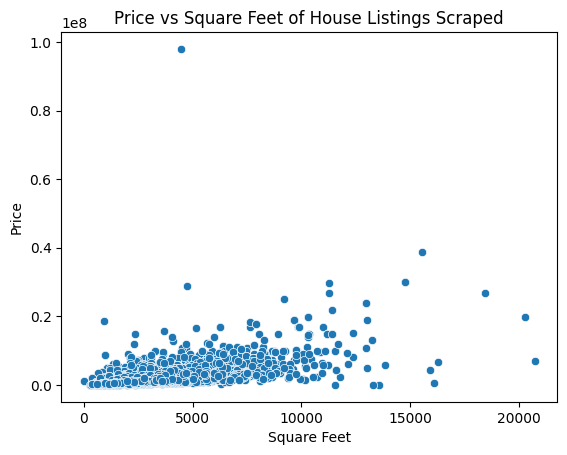

In [159]:
## Let's see a scatterplot of price vs square footage:
sns.scatterplot(data=df, x='Square Feet', y='Price')
plt.title("Price vs Square Feet of House Listings Scraped")

Text(0.5, 1.0, 'Price vs Square Feet of House Listings Scraped')

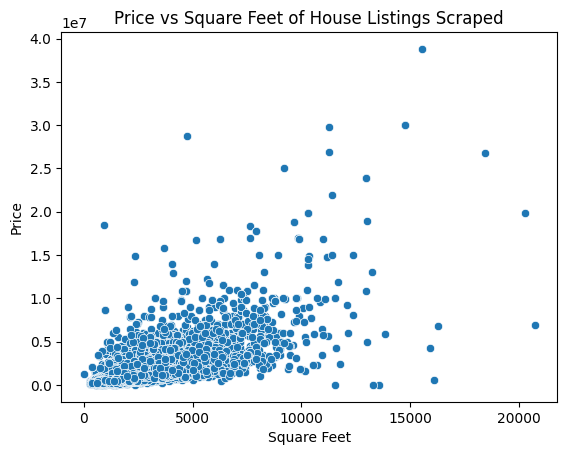

In [160]:
## Let's remove this fake 98 million dollar listing and try again:
df = df.drop(df[df['Price'] > 50000000].index)
sns.scatterplot(data=df, x='Square Feet', y='Price')
plt.title("Price vs Square Feet of House Listings Scraped")

In [161]:
## Now we can see there are some VERY cheap listings, I will look closer...
df[df['Price'] < 10000]

,Province,City,Price,Square Feet,Baths,Bedrooms,Property Type,Year Built
17274,ON,Kitchener,2700.0,1357.0,3.0,3.0,TOWNHOUSE,2022.0
17608,ON,Oakville,2.0,13585.0,9.0,6.0,SINGLE_FAMILY_HOUSE,2006.0
17856,ON,Burlington,2.0,11563.0,10.0,7.0,SINGLE_FAMILY_HOUSE,1988.0
19036,ON,Windsor,2695.0,1500.0,2.0,2.0,SINGLE_FAMILY_HOUSE,1988.0
23000,ON,Vaughan,1.0,13295.0,9.0,5.0,SINGLE_FAMILY_HOUSE,2016.0
28353,ON,Brant,4.0,2346.0,2.0,3.0,FARM,2014.0


Text(0.5, 1.0, 'Price vs Square Feet of House Listings Scraped')

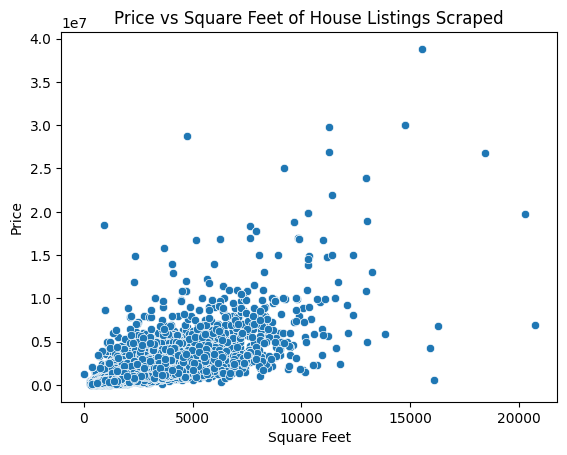

In [162]:
## These cheap listings are clearly an error so let's remove them and try again:
df = df.drop(df[df['Price'] < 10000].index)
sns.scatterplot(data=df, x='Square Feet', y='Price')
plt.title("Price vs Square Feet of House Listings Scraped")

In [163]:
# Let's save this Dataframe to a csv file for future use
df = df.reset_index(drop=True)
df.to_csv("housesDF.csv", index=False)

<Axes: xlabel='Year Built', ylabel='Count'>

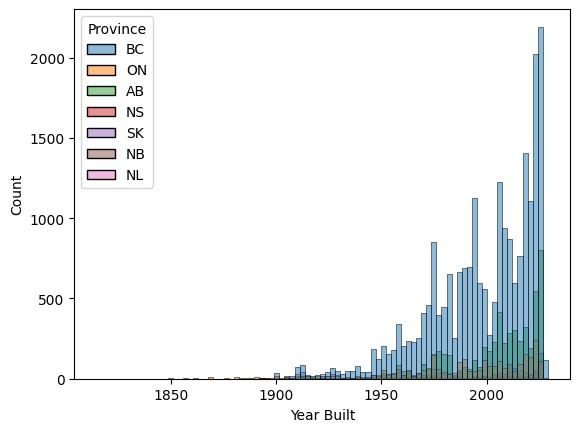

In [164]:
sns.histplot(data=df, x='Year Built', hue='Province')